<a href="https://colab.research.google.com/github/wissalferc/LGM/blob/main/ML_Facial_recognition_to_detect_mood_and_suggest_songs_accordingly/ML_Facial_recognition_to_detect_mood_and_suggest_songs_accordingly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wissal Ferchichi
# ML Facial recognition to detect mood and suggest songs accordingly

### Dataset link : https://www.kaggle.com/msambare/fer2013

In [1]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing Libraries

In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Import Libraries/Packages
import tensorflow
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio

In [4]:
print("TensorFlow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version : 2.9.2
Num GPUs Available:  0


### Data Visualization

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!unzip "/content/gdrive/MyDrive/archive (1).zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

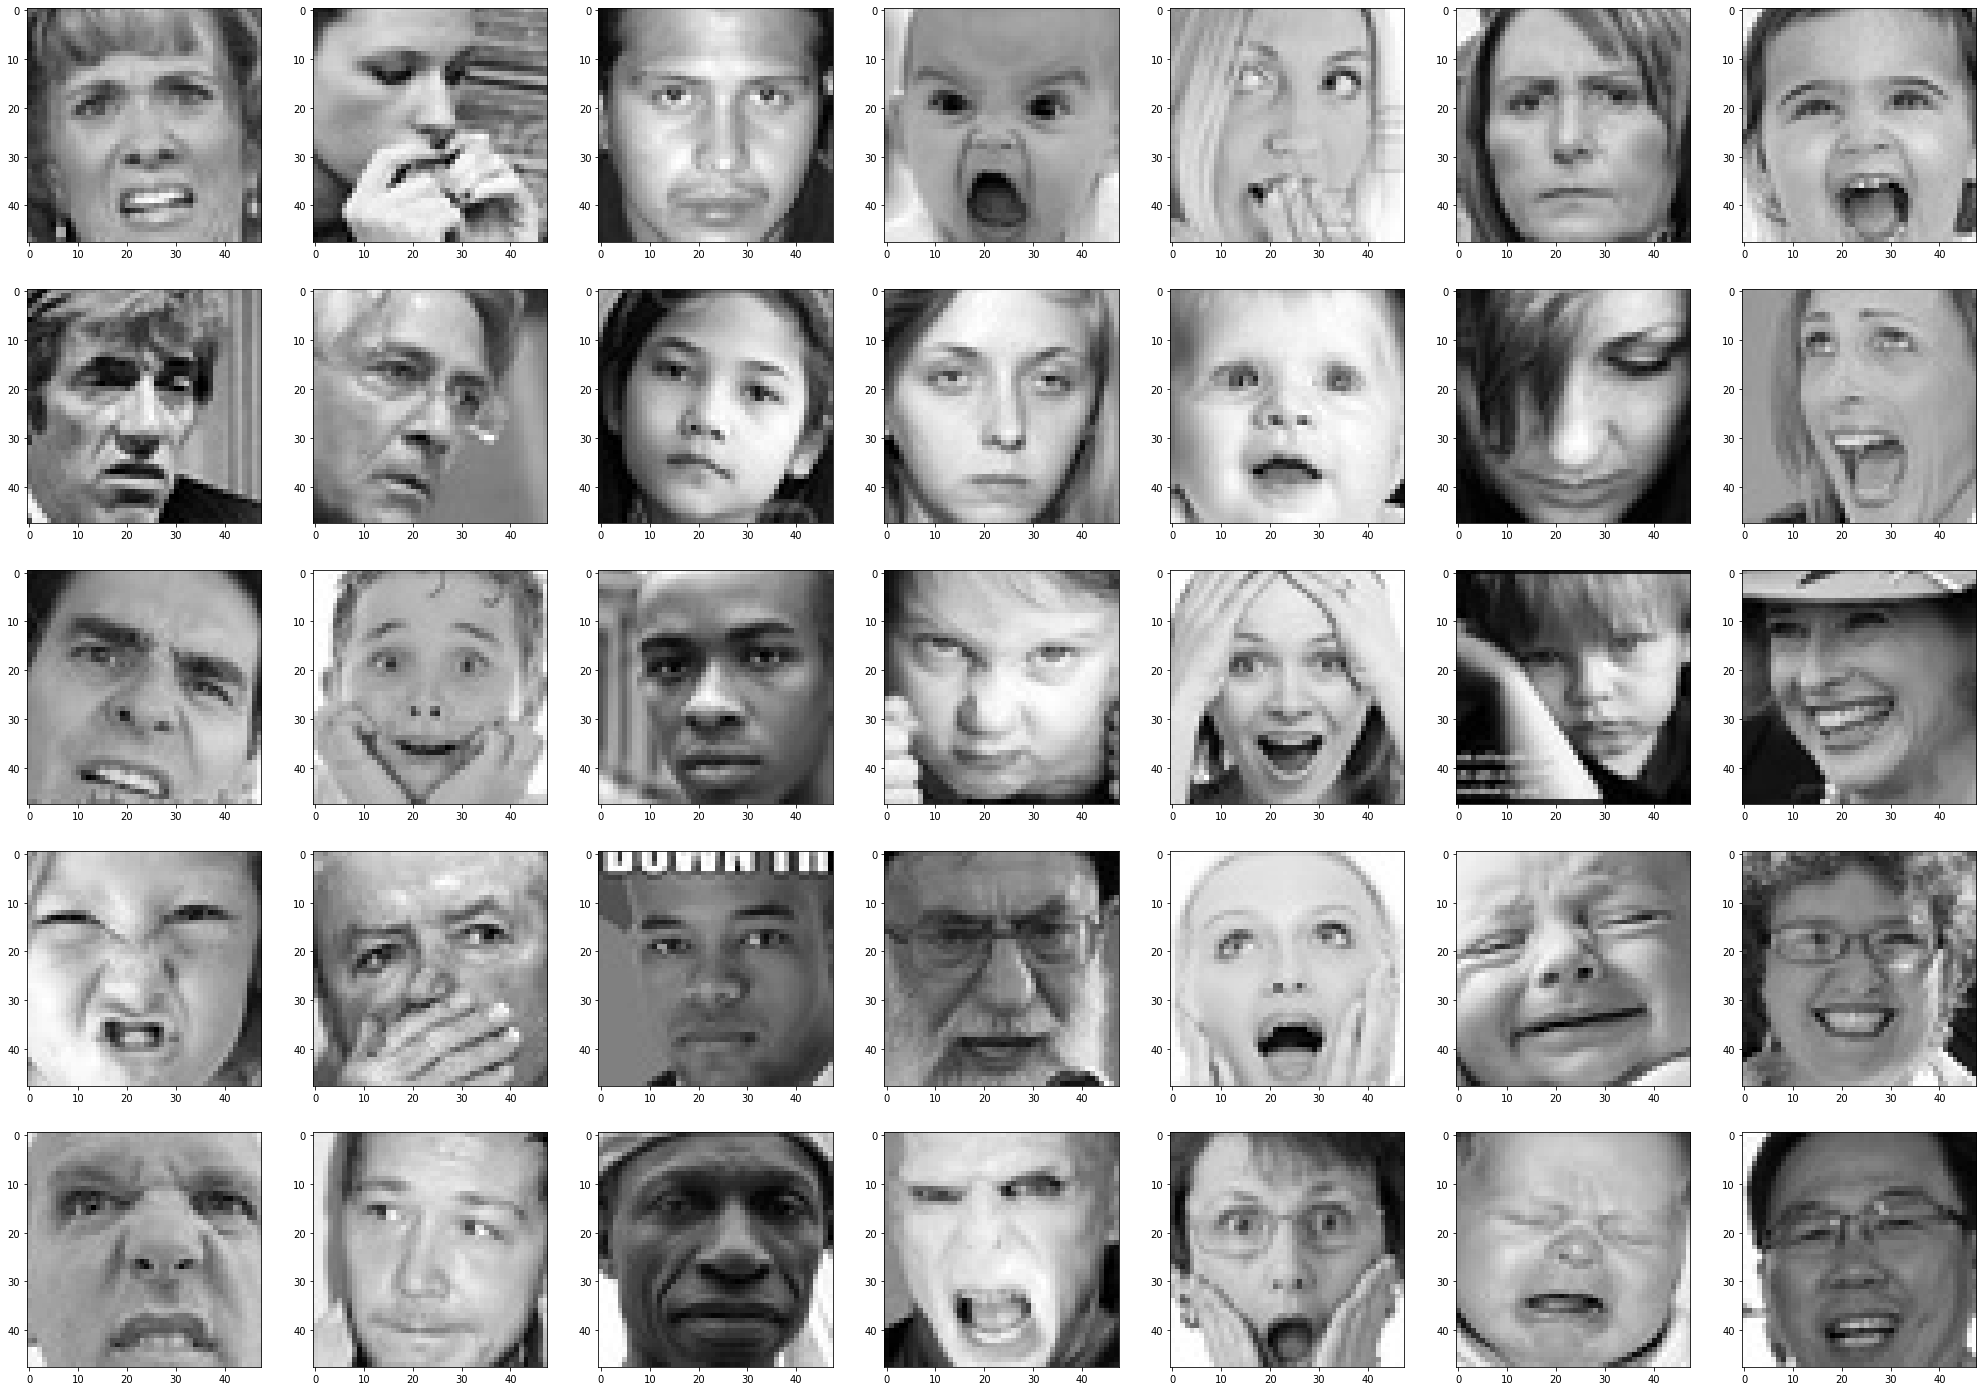

In [10]:
# Data Visualization
from skimage.io import imread
train_dir = "/content/train/"
test_dir = "/content/test/"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

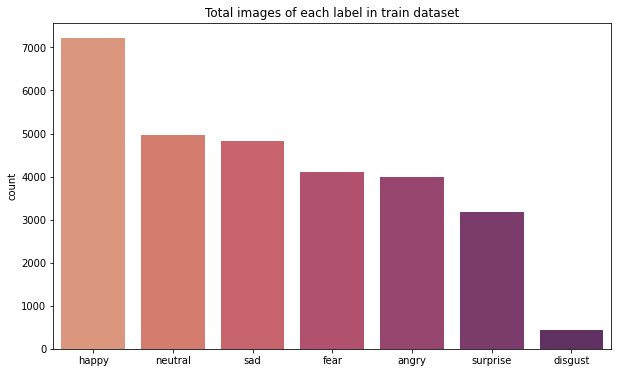

In [11]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=df.index, y="total", palette="flare", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


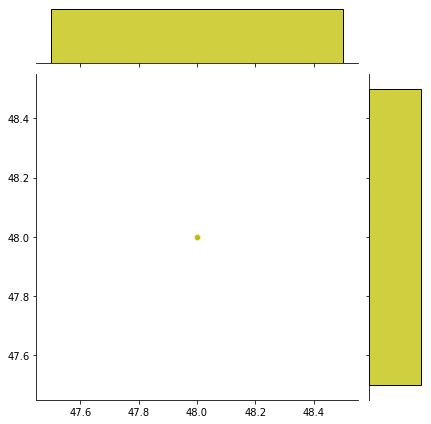

In [12]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
sns.jointplot(dim1, dim2,color='y')
plt.show()

In [13]:
# Data Preprocessing
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Creating the Model

In [14]:
# Create the Model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

### Training the model

In [15]:
# Train the model
model.compile(optimizer=Adam(learning_rate=0.0001, 
                             decay=1e-6), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [17]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 3

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/3
448/448 [==============================] - 1189s 3s/step - loss: 1.5572 - accuracy: 0.3854 - val_loss: 1.5249 - val_accuracy: 0.3814
Epoch 2/3
448/448 [==============================] - 1166s 3s/step - loss: 1.5274 - accuracy: 0.4011 - val_loss: 1.5213 - val_accuracy: 0.4188
Epoch 3/3
448/448 [==============================] - 1149s 3s/step - loss: 1.4963 - accuracy: 0.4184 - val_loss: 1.3904 - val_accuracy: 0.4456


### Saving the trained model

In [28]:
model.save("model.h5")

### Evaluating the model

In [19]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 68s 600ms/step - loss: 1.3891 - accuracy: 0.4462
validation accuracy : 44.6224570274353%
validation loss : 1.389074683189392


### Plotting Training and Validation plot

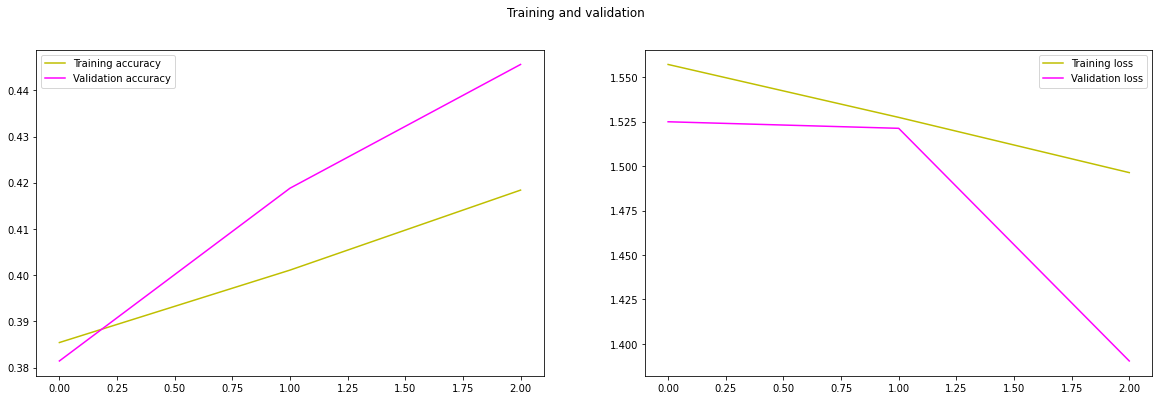

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'y', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'magenta', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'y', label='Training loss')
ax[1].plot(epochs, val_loss, 'magenta', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

### Plotting the confusion matrix

113/113 [==============================] - 65s 566ms/step
              precision    recall  f1-score   support

       angry       0.23      0.62      0.34       958
     disgust       0.00      0.00      0.00       111
        fear       0.29      0.07      0.12      1024
       happy       0.72      0.72      0.72      1774
     neutral       0.48      0.30      0.37      1233
         sad       0.41      0.21      0.28      1247
    surprise       0.52      0.75      0.62       831

    accuracy                           0.45      7178
   macro avg       0.38      0.38      0.35      7178
weighted avg       0.47      0.45      0.42      7178





/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


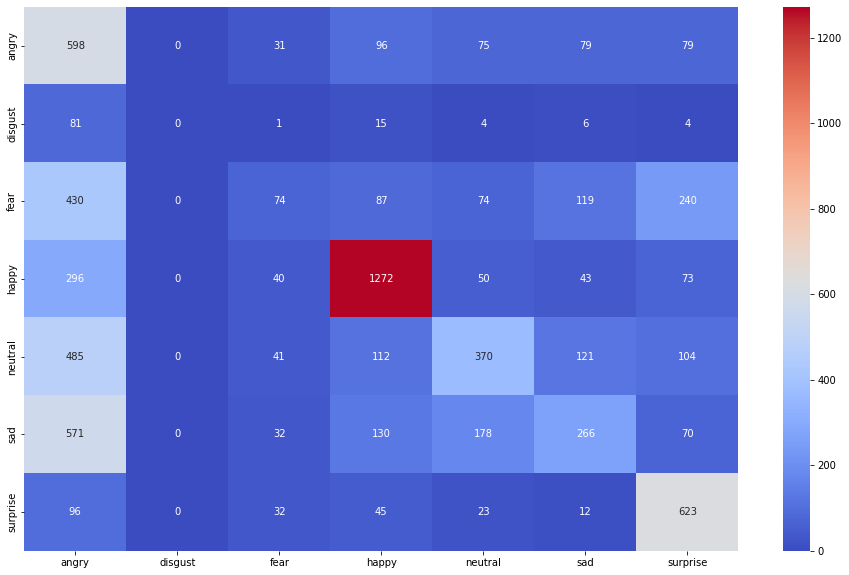

In [21]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.coolwarm, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

### Testing our model with new image

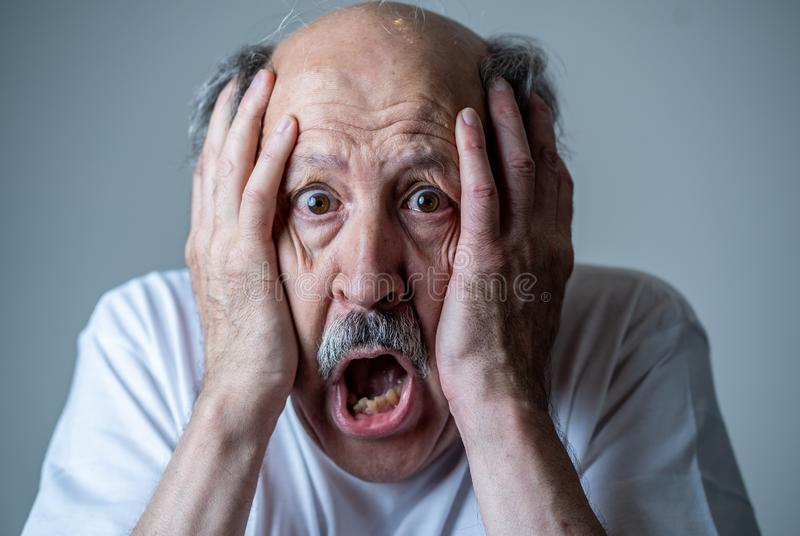

In [48]:
# Testing our model with new image
image = cv2.imread("/content/close-up-portrait-scared-frightened-old-man-expression-fear-human-emotions-facial-expressions-neutral-background-128517042.jpg")
from IPython.display import Image
Image(filename='/content/close-up-portrait-scared-frightened-old-man-expression-fear-human-emotions-facial-expressions-neutral-background-128517042.jpg')

### Model Prediction

In [49]:
# Model Prediction
import cv2
from tensorflow.python.keras.models import load_model
from tensorflow.keras.models import load_model
import os
# # load the trained model
model = load_model("model.h5")
# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Load image
img = image

# Trim the image to 48 x 48, and turn the grayscale image, normalization
frame = cv2.resize(img,(48,48),interpolation=cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reinvent the image dimension
gray = gray.reshape(1,48,48,1)

# Output the prediction
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i,j) in zip(range(7),EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j)+"prediction rate is   {0:.2f}%".format(predictss))
print( "\n\n The system considers this expression to be:",label)

1/1 [==============================] - 0s 147ms/step
  Angry   prediction rate is   0.18%
 Disgust  prediction rate is   0.01%
  Happy   prediction rate is   0.42%
   Sad    prediction rate is   0.06%
 Surprise prediction rate is   0.10%
 Neutral  prediction rate is   0.12%


 The system considers this expression to be: Happy


### Song Recommdation

In [50]:
# Song Recommdation
if (label=='Angry'):
    path="/content/gdrive/MyDrive/Song/Angry/"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='/content/gdrive/MyDrive/Song/Angry/'+ d,autoplay=True)
    display(audio)
    
elif (label=='Disgust'):
    path="/content/gdrive/MyDrive/Song/Disgust/"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='/content/gdrive/MyDrive/Song/Disgust/'+ d,autoplay=True)
    display(audio)
    
elif (label=="Happy"):
    path="/content/gdrive/MyDrive/Song/Happy/"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='/content/gdrive/MyDrive/Song/Happy/'+ d,autoplay=True)
    display(audio)
    
elif (label=='Sad'):
    path="/content/gdrive/MyDrive/Song/Sad/"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='/content/gdrive/MyDrive/Song/Sad/'+ d,autoplay=True)
    display(audio)
    
elif (label=='Surprise'):
    path="/content/gdrive/MyDrive/Song/Surprise/"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='/content/gdrive/MyDrive/Song/Surprise/'+ d,autoplay=True)
    display(audio)
    
elif (label=='Neutral'):
    path="/content/gdrive/MyDrive/Song/Neutral/"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='/content/gdrive/MyDrive/Song/Neutral/'+ d,autoplay=True)
    display(audio)

Now Playing: Levitating.mp3


# THANK YOU!!:))